In [1]:
%matplotlib inline
from __future__ import division,print_function

import os, json
from glob import glob
import numpy as np
np.set_printoptions(precision=4, linewidth=100)
from matplotlib import pyplot as plt
import utils; reload(utils)
from utils import plots, get_data, get_batches
import os, json
from glob import glob
import numpy as np
from scipy import misc, ndimage
from scipy.ndimage.interpolation import zoom
from sklearn.preprocessing import OneHotEncoder
import pandas as pd

from keras import backend as K
from keras.layers.normalization import BatchNormalization
from keras.utils.data_utils import get_file
from keras.models import Sequential
from keras.layers.core import Flatten, Dense, Dropout, Lambda
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.layers.pooling import GlobalAveragePooling2D
from keras.optimizers import SGD, RMSprop, Adam
from keras.preprocessing import image

WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

Using gpu device 0: Quadro M4000 (CNMeM is disabled, cuDNN 5105)
Using Theano backend.


In [2]:
path = "data/dogscats/"
#path = "data/dogscats/sample/"
model_path = path + 'models/'
if not os.path.exists(model_path): os.mkdir(model_path)

In [3]:
FILE_PATH = 'http://www.platform.ai/models/'
fn = 'imagenet_class_index.json'
get_file(fn, FILE_PATH + fn, cache_subdir='models')
fn = 'vgg16.h5'
vgg_weights = get_file(fn, FILE_PATH + fn, cache_subdir='models')

In [4]:
val_batches = get_batches(path+'valid', shuffle=False, batch_size=1)
batches = get_batches(path+'train', shuffle=False, batch_size=1)

Found 2000 images belonging to 2 classes.
Found 23000 images belonging to 2 classes.


In [5]:
vgg_mean = np.array([123.68, 116.779, 103.939], dtype=np.float32).reshape((3, 1, 1))
def preproc(x):
    x = x - vgg_mean
    return x[:, ::-1] # reverse color order

def conv(model, layers, filters):
    for _ in range(layers):
        model.add(ZeroPadding2D((1, 1)))
        model.add(Convolution2D(filters, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

def fc(model):
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(0.5))

def new_model():
    model = Sequential()
    model.add(Lambda(preproc, input_shape=(3, 224, 224), output_shape=(3, 224, 224)))
    conv(model, 2, 64)
    conv(model, 2, 128)
    conv(model, 3, 256)
    conv(model, 3, 512)
    conv(model, 3, 512)

    model.add(Flatten())
    fc(model)
    fc(model)
    model.add(Dense(1000, activation='softmax'))

    model.load_weights(vgg_weights)
    return model

In [6]:
def render_history(history):
    # summarize history for accuracy
    plt.subplot(2, 1, 1)
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')

    # summarize history for loss
    plt.subplot(2, 1, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')

In [7]:
import bcolz
def save_array(fname, arr): c=bcolz.carray(arr, rootdir=fname, mode='w'); c.flush()
def load_array(fname): return bcolz.open(fname)[:]

In [7]:
# Only need to run this if we don't have the data processed
# save_array(model_path+ 'train_data.bc', get_data(path+'train'))
# save_array(model_path + 'valid_data.bc', get_data(path+'valid'))

In [8]:
val_batches = get_batches(path+'valid', shuffle=False, batch_size=1)
batches = get_batches(path+'train', shuffle=False, batch_size=1)
trn_data = load_array(model_path+'train_data.bc')
val_data = load_array(model_path+'valid_data.bc')

Found 2000 images belonging to 2 classes.
Found 23000 images belonging to 2 classes.


In [9]:
def onehot(x): return OneHotEncoder().fit_transform(x.reshape(-1, 1)).todense()
train_targets = onehot(batches.classes)
validation_targets = onehot(val_batches.classes)

In [10]:
def fit_model(model, batches, val_batches, nb_epoch=1):
    return model.fit_generator(batches, samples_per_epoch=batches.n, nb_epoch=nb_epoch, 
                        validation_data=val_batches, nb_val_samples=val_batches.n)

model = new_model()
model.pop()
for layer in model.layers: layer.trainable = False
model.add(Dense(2, activation='softmax'))

In [11]:
batch_size = 100
gen = image.ImageDataGenerator()
train_b = gen.flow(trn_data, train_targets, batch_size=batch_size, shuffle=True)
val_b = gen.flow(val_data, validation_targets, batch_size=batch_size, shuffle=False)

In [14]:
opt = RMSprop(lr=.1)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

In [25]:
history = model.fit_generator(train_b, samples_per_epoch=2000, nb_epoch=10, 
                        validation_data=val_b, nb_val_samples=val_b.n)

Epoch 1/10
2000/2000 [==============================] - 90s - loss: 0.7082 - acc: 0.9540 - val_loss: 0.4846 - val_acc: 0.9680
Epoch 2/10
2000/2000 [==============================] - 90s - loss: 0.7944 - acc: 0.9490 - val_loss: 0.7574 - val_acc: 0.9515
Epoch 3/10
2000/2000 [==============================] - 90s - loss: 0.7705 - acc: 0.9500 - val_loss: 0.5799 - val_acc: 0.9635
Epoch 4/10
2000/2000 [==============================] - 90s - loss: 0.5299 - acc: 0.9655 - val_loss: 0.4791 - val_acc: 0.9695
Epoch 5/10
2000/2000 [==============================] - 90s - loss: 0.8323 - acc: 0.9460 - val_loss: 0.4841 - val_acc: 0.9685
Epoch 6/10
2000/2000 [==============================] - 90s - loss: 0.5028 - acc: 0.9680 - val_loss: 0.5099 - val_acc: 0.9665
Epoch 7/10
2000/2000 [==============================] - 90s - loss: 0.5320 - acc: 0.9665 - val_loss: 0.7412 - val_acc: 0.9530
Epoch 8/10
2000/2000 [==============================] - 90s - loss: 0.5891 - acc: 0.9620 - val_loss: 0.5427 - val_acc:

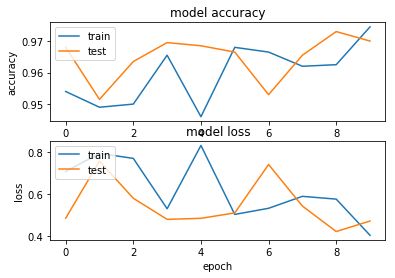

In [28]:
render_history(history)

In [26]:
model.save_weights(model_path+'finetune1.h5')

Now let's train the fully-connected layers!

In [31]:
dense_idx = next(idx for idx, layer in enumerate(model.layers) if type(layer) is Dense)
for layer in model.layers[dense_idx:]: layer.trainable = True
K.set_value(opt.lr, 0.01)
history = model.fit_generator(train_b, samples_per_epoch=2000, nb_epoch=10, 
                        validation_data=val_b, nb_val_samples=val_b.n)

Epoch 1/10
2000/2000 [==============================] - 90s - loss: 0.4976 - acc: 0.9675 - val_loss: 0.4748 - val_acc: 0.9700
Epoch 2/10
2000/2000 [==============================] - 90s - loss: 0.4659 - acc: 0.9705 - val_loss: 0.4744 - val_acc: 0.9700
Epoch 3/10
2000/2000 [==============================] - 90s - loss: 0.4458 - acc: 0.9720 - val_loss: 0.4397 - val_acc: 0.9720
Epoch 4/10
2000/2000 [==============================] - 90s - loss: 0.4994 - acc: 0.9680 - val_loss: 0.4206 - val_acc: 0.9730
Epoch 5/10
2000/2000 [==============================] - 90s - loss: 0.3930 - acc: 0.9755 - val_loss: 0.4354 - val_acc: 0.9725
Epoch 6/10
2000/2000 [==============================] - 90s - loss: 0.4874 - acc: 0.9685 - val_loss: 0.4745 - val_acc: 0.9705
Epoch 7/10
2000/2000 [==============================] - 90s - loss: 0.4126 - acc: 0.9735 - val_loss: 0.4183 - val_acc: 0.9735
Epoch 8/10
2000/2000 [==============================] - 90s - loss: 0.5122 - acc: 0.9675 - val_loss: 0.4594 - val_acc:

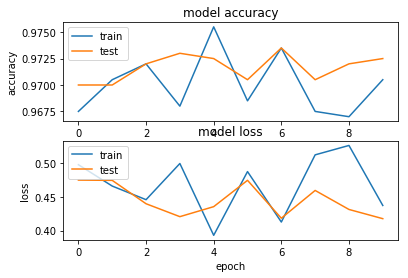

In [33]:
render_history(history)

In [32]:
model.save_weights(model_path+'finetune2.h5')

Now let's prep for submission!

In [27]:
# HACK setting classes=['.'] to avoid restructuring formats on disk
test_b = gen.flow_from_directory(path+'test1', batch_size=1, shuffle=False,
                                 class_mode=None, classes=['.'], target_size=(224,224))
# HACK this code loads the test data to save it
# test_data = np.concatenate([test_b.next() for i in range(test_b.nb_sample)])
# save_array(model_path + 'test_data.bc', test_data)

Found 12500 images belonging to 1 classes.


In [22]:
test_data = load_array(model_path+'test_data.bc')

In [23]:
model.load_weights(model_path+'finetune1.h5')
model.evaluate(val_data, validation_targets)

2000/2000 [==============================] - 45s    


[0.47119597864151536, 0.96999999999999997]

In [24]:
test_labels = model.predict_proba(test_data)

12500/12500 [==============================] - 283s   


In [46]:
sub = pd.DataFrame({
    'id': test_b.filenames,
    'label': test_labels[:, batches.class_indices['dogs']],
}, columns=['id', 'label'])
# and parse the filename
sub['id'] = sub['id'].apply(lambda fn: os.path.basename(fn).split('.')[0])
sub.set_index('id', inplace=True)
sub['label'] = np.clip(sub['label'], .025, .975)
sub.to_csv('dogs-vs-cats-redux-kernels-edition.csv')